# Extract annotation information from UniProt

Note: Requires internet connection to download information from the UniProt.

## Setup
### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    ANNOTATION_PATH,
    COBRA_CONFIGURATION,
    DATABASE_PATH,
    INTERIM_PATH,
    ROOT_PATH,
    compare_tables,
    read_rbc_model,
    show_versions,
    visualize_comparison,
)
from rbc_gem_utils.database.uniprot import (
    UNIPROT_EXPECTED_VERSION,
    get_isoform_value_from_entry_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    get_version_UniProt,
    parse_isoforms_UniProt,
    query_UniProt,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
cobra      0.29.0
depinfo     2.2.0
matplotlib  3.8.2
memote     0.16.1
notebook    7.0.6
requests   2.31.0
scipy      1.11.4
seaborn    0.13.0

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
--------------------
Darwin  22.6.0-x86_64
CPython        3.12.0


### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Check UniProt version
If the UniProt version does not match the expected version, it is because UniProt has been updated since the last time this code was utilized. 

### Expected UniProt version: 2023_05
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 
* Last release utilized: [2023_05](https://www.uniprot.org/uniprotkb/statistics) published on **Wed Nov 08 2023**.

In [3]:
version = get_version_UniProt()
try:
    assert (
        UNIPROT_EXPECTED_VERSION == version
    ), "Expected and retrieved versions are not the same"
except AssertionError as e:
    warn("Expected and retrieved versions are not the same")
    print(f"Expected UniProt version: {UNIPROT_EXPECTED_VERSION}")
    print(f"Retrieved UniProt version {version}.")
else:
    print("Retrieved version matches expected version.")

Retrieved version matches expected version.


In [4]:
if UNIPROT_EXPECTED_VERSION != version:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
else:
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"

## Load RBC-GEM model
### Current Version: 0.2.0

In [5]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,iAB_RBC_283
Memory address,149538fb0
Number of metabolites,342
Number of reactions,469
Number of genes,349
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Download data from UniProt

### Get IDs for query
#### Using a customized method

In [6]:
from_db = "GeneID"  # From NCBI Gene ID

annotation_type = "genes"
annotation_key = "custom"

df_model = pd.DataFrame.from_dict(
    {gene.id: gene.id.split("_AT")[0] for gene in model.genes},
    orient="index",
    columns=[annotation_key],
)
df_model.index.name = annotation_type
df_model = df_model.reset_index(drop=False)


query_ids = df_model[annotation_key].unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model.set_index(annotation_type)[annotation_key].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")

Number of model genes associated with query: 349
Number of unique IDs to query: 283


### Set universal query parameters

In [7]:
miriam_query_fields = get_query_fields_UniProt(miriam_only=True)
miriam_query_fields

['accession',
 'gene_primary',
 'organism_id',
 'cc_alternative_products',
 'uniparc_id',
 'xref_ccds',
 'xref_embl',
 'xref_refseq',
 'xref_bmrb',
 'xref_pdb',
 'xref_sasbdb',
 'xref_smr',
 'xref_biogrid',
 'xref_corum',
 'xref_complexportal',
 'xref_dip',
 'xref_elm',
 'xref_intact',
 'xref_mint',
 'xref_string',
 'xref_bindingdb',
 'xref_chembl',
 'xref_drugbank',
 'xref_drugcentral',
 'xref_swisslipids',
 'xref_allergome',
 'xref_cazy',
 'xref_ideal',
 'xref_merops',
 'xref_peroxibase',
 'xref_rebase',
 'xref_tcdb',
 'xref_depod',
 'xref_phosphositeplus',
 'xref_dbsnp',
 'xref_compluyeast-2dpage',
 'xref_epd',
 'xref_massive',
 'xref_maxqb',
 'xref_pride',
 'xref_paxdb',
 'xref_peptideatlas',
 'xref_proteomicsdb',
 'xref_ensembl',
 'xref_geneid',
 'xref_kegg',
 'xref_ctd',
 'xref_genecards',
 'xref_hgnc',
 'xref_hpa',
 'xref_mim',
 'xref_nextprot',
 'xref_orphanet',
 'xref_pharmgkb',
 'xref_eggnog',
 'xref_genetree',
 'xref_hogenom',
 'xref_oma',
 'xref_orthodb',
 'xref_phylomedb',

In [8]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:9606)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(miriam_query_fields),
}

## Run queries

In [9]:
database_tag = "UniProt"
compare = True
overwrite = True

all_query_results = {}

### Initial query

In [10]:
query_key = "initial"
df_results, failed_ids = query_UniProt(
    query_ids,
    query_parameters=query_parameters,
    from_db="GeneID",
)
if failed_ids:
    print(failed_ids)
all_query_results[query_key] = df_results
df_results

Number of failed query IDs : 3


Fetched: 280 / 280
['2713', '2974', '6526']


,From,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),UniParc,CCDS,EMBL,RefSeq,BMRB,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
0,5138,O00408,PDE2A,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI000003B340,CCDS44670.1 [O00408-3];CCDS53678.1 [O00408-4];...,U67733;AY495087;AY495088;AY495089;AK092278;AK1...,NP_001137311.1 [O00408-3];NP_001139681.1 [O004...,,...,,IPR003018;IPR029016;IPR003607;IPR023088;IPR002...,PTHR11347:SF102;PTHR11347;,PF01590;PF13185;PF00233;,,PR00387;,,PS00126;PS51845;,SM00065;SM00471;,SSF55781;SSF109604;
1,8789,O00757,FBP2,9606,ALTERNATIVE PRODUCTS:,UPI000013CDC2,CCDS6711.1;,Y10812;CR536483;AL161728;BC113632;BC117477;,NP_003828.2;,,...,MF_01855;,IPR044015;IPR000146;IPR033391;IPR028343;IPR020...,PTHR11556:SF13;PTHR11556;,PF00316;PF18913;,PIRSF500210;PIRSF000904;,PR00115;,,PS00124;,,SSF56655;
2,8566,O00764,PDXK,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000131524,CCDS13699.1 [O00764-1];,U89606;AY303972;AP001752;BC000123;BC005825;,NP_003672.1 [O00764-1];XP_005261256.1 [O00764-...,,...,,IPR013749;IPR004625;IPR029056;,PTHR10534;PTHR10534:SF2;,PF08543;,,,,,,SSF53613;
3,8611,O14494,PLPP1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000073CF9,CCDS34159.1 [O14494-1];CCDS34160.1 [O14494-2];,AB000888;AF014402;AF014403;Y14436;AF017116;AC0...,NP_003702.2 [O14494-1];NP_795714.1 [O14494-2];,,...,,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF26;,PF01569;,,,,,SM00014;,SSF48317;
4,8613,O14495,PLPP3,9606,ALTERNATIVE PRODUCTS:,UPI000006F261,CCDS604.1;,AB000889;AF017786;AF480883;AF043329;U79294;AK3...,NP_003704.3;,,...,,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF79;,PF01569;,,,,,SM00014;,SSF48317;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,9468,Q9Y5K3,PCYT1B,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI000012864E,CCDS14213.1 [Q9Y5K3-1];CCDS55391.1 [Q9Y5K3-2];...,AF052510;AF148464;AK296333;AK315323;EU181262;A...,NP_001156736.1 [Q9Y5K3-4];NP_001156737.1 [Q9Y5...,,...,,IPR041723;IPR004821;IPR045049;IPR014729;,PTHR10739:SF20;PTHR10739;,PF01467;,,,,,,SSF52374;
276,10723,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000141815,CCDS34129.1 [Q9Y666-1];,AF105365;AC116351;BC007760;BC098390;AK024493;A...,NP_006589.2 [Q9Y666-1];,,...,,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,,PR01081;,,,,
277,10390,Q9Y6K0,CEPT1,9606,ALTERNATIVE PRODUCTS:,UPI0000062325,CCDS830.1;,AF068302;AF138862;AL355816;BC032610;BC049196;A...,NP_001007795.1;NP_001317672.1;NP_006081.1;,,...,,IPR000462;IPR043130;IPR014472;,PTHR10414:SF27;PTHR10414;,PF01066;,PIRSF015665;,,,PS00379;,,
278,10599,Q9Y6L6,SLCO1B1,9606,ALTERNATIVE PRODUCTS:,UPI0000043BED,CCDS8685.1;,AF060500;AF205071;AJ132573;AB026257;AJ400749;A...,NP_006437.3;,,...,,IPR002350;IPR036058;IPR020846;IPR036259;IPR004...,PTHR11388;PTHR11388:SF82;,PF07648;PF03137;,,,,PS51465;PS50850;,,SSF100895;SSF103473;


### Address failed IDs
IDs that failed mapping are all pseudogenes in this case. 
They have UniProt IDs that can be looked up.

In [11]:
retry_ids = {
    # Failed ID, new ID
    "2713": "Q14409",
    "2974": "O75343",
    "6526": "P53794",
}

In [12]:
query_key = "retry_1"
df_results, failed_ids = query_UniProt(
    list(sorted(retry_ids.values())),
    from_db="UniProtKB",
    query_parameters=query_parameters,
)
if failed_ids:
    print(failed_ids)
all_query_results[query_key] = df_results
model_search_mapping.update(
    {
        k: retry_ids[v]
        for k, v in model_search_mapping.items()
        if v in retry_ids and v not in failed_ids
    }
)
df_results

Fetched: 3 / 3


,From,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),UniParc,CCDS,EMBL,RefSeq,BMRB,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
0,O75343,O75343,GUCY1B2,9606,ALTERNATIVE PRODUCTS:,UPI0000128C13,,AF038499;AF218383;,,,...,,IPR001054;IPR018297;IPR038158;IPR011644;IPR011...,PTHR45655;PTHR45655:SF17;,PF00211;PF07700;PF07701;,,,,PS00452;PS50125;,SM00044;,SSF111126;SSF55073;
1,P53794,P53794,SLC5A3,9606,ALTERNATIVE PRODUCTS:,UPI0000EE4C60,CCDS33549.1;,L38500;AF027153;AP001719;,,,...,,IPR038377;IPR001734;IPR018212;IPR042731;,PTHR11819:SF150;PTHR11819;,PF00474;,,,,PS00456;PS00457;PS50283;,,
2,Q14409,Q14409,GK3,9606,ALTERNATIVE PRODUCTS:,UPI000013EB4C,,X78711;AC107059;BC066960;,,,...,,IPR043129;IPR000577;IPR018485;IPR018483;IPR018...,PTHR10196:SF95;PTHR10196;,PF02782;PF00370;,PIRSF000538;,,,PS00933;PS00445;,,SSF53067;


## Map query results to model
### Concat and cleanup query results

In [13]:
print(f"Number of unique queries: {len(all_query_results)}")
df_query_results = pd.concat(tuple(all_query_results.values()))
df_query_results = df_query_results.set_index("From").drop_duplicates()
df_query_results = df_query_results.replace("", float("nan"))
df_query_results

Number of unique queries: 2


,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),UniParc,CCDS,EMBL,RefSeq,BMRB,PDB,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
From,,,,,,,,,,,,,,,,,,,,,
5138,O00408,PDE2A,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI000003B340,CCDS44670.1 [O00408-3];CCDS53678.1 [O00408-4];...,U67733;AY495087;AY495088;AY495089;AK092278;AK1...,NP_001137311.1 [O00408-3];NP_001139681.1 [O004...,NaN,1Z1L;3IBJ;3ITM;3ITU;4C1I;4D08;4D09;4HTX;4HTZ;4...,...,NaN,IPR003018;IPR029016;IPR003607;IPR023088;IPR002...,PTHR11347:SF102;PTHR11347;,PF01590;PF13185;PF00233;,NaN,PR00387;,NaN,PS00126;PS51845;,SM00065;SM00471;,SSF55781;SSF109604;
8789,O00757,FBP2,9606,ALTERNATIVE PRODUCTS:,UPI000013CDC2,CCDS6711.1;,Y10812;CR536483;AL161728;BC113632;BC117477;,NP_003828.2;,NaN,3IFA;3IFC;4HE0;4HE1;4HE2;5ET5;5ET6;5ET7;5ET8;5...,...,MF_01855;,IPR044015;IPR000146;IPR033391;IPR028343;IPR020...,PTHR11556:SF13;PTHR11556;,PF00316;PF18913;,PIRSF500210;PIRSF000904;,PR00115;,NaN,PS00124;,NaN,SSF56655;
8566,O00764,PDXK,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000131524,CCDS13699.1 [O00764-1];,U89606;AY303972;AP001752;BC000123;BC005825;,NP_003672.1 [O00764-1];XP_005261256.1 [O00764-...,NaN,2AJP;2F7K;2YXT;2YXU;3FHX;3FHY;3KEU;4EN4;4EOH;,...,NaN,IPR013749;IPR004625;IPR029056;,PTHR10534;PTHR10534:SF2;,PF08543;,NaN,NaN,NaN,NaN,NaN,SSF53613;
8611,O14494,PLPP1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000073CF9,CCDS34159.1 [O14494-1];CCDS34160.1 [O14494-2];,AB000888;AF014402;AF014403;Y14436;AF017116;AC0...,NP_003702.2 [O14494-1];NP_795714.1 [O14494-2];,NaN,NaN,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF26;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
8613,O14495,PLPP3,9606,ALTERNATIVE PRODUCTS:,UPI000006F261,CCDS604.1;,AB000889;AF017786;AF480883;AF043329;U79294;AK3...,NP_003704.3;,NaN,NaN,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF79;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10599,Q9Y6L6,SLCO1B1,9606,ALTERNATIVE PRODUCTS:,UPI0000043BED,CCDS8685.1;,AF060500;AF205071;AJ132573;AB026257;AJ400749;A...,NP_006437.3;,NaN,NaN,...,NaN,IPR002350;IPR036058;IPR020846;IPR036259;IPR004...,PTHR11388;PTHR11388:SF82;,PF07648;PF03137;,NaN,NaN,NaN,PS51465;PS50850;,NaN,SSF100895;SSF103473;
1607,Q9Y6T7,DGKB,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000033B9B,CCDS47547.1 [Q9Y6T7-1];CCDS47548.1 [Q9Y6T7-2];,AX032742;AC005039;AC005248;AC006150;AC011229;A...,NP_004071.1;NP_663733.1 [Q9Y6T7-2];XP_00524968...,NaN,NaN,...,NaN,IPR017438;IPR046349;IPR047471;IPR047470;IPR029...,PTHR11255;PTHR11255:SF32;,PF00130;PF14513;PF00609;PF00781;PF13499;,NaN,NaN,NaN,PS50146;PS00018;PS50222;PS00479;PS50081;,SM00109;SM00045;SM00046;SM00054;,SSF57889;SSF47473;SSF111331;
O75343,O75343,GUCY1B2,9606,ALTERNATIVE PRODUCTS:,UPI0000128C13,NaN,AF038499;AF218383;,NaN,NaN,NaN,...,NaN,IPR001054;IPR018297;IPR038158;IPR011644;IPR011...,PTHR45655;PTHR45655:SF17;,PF00211;PF07700;PF07701;,NaN,NaN,NaN,PS00452;PS50125;,SM00044;,SSF111126;SSF55073;


### Save extracted data to database

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),UniParc,CCDS,EMBL,RefSeq,BMRB,PDB,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
0,O00408,PDE2A,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI000003B340,CCDS44670.1 [O00408-3];CCDS53678.1 [O00408-4];...,U67733;AY495087;AY495088;AY495089;AK092278;AK1...,NP_001137311.1 [O00408-3];NP_001139681.1 [O004...,NaN,1Z1L;3IBJ;3ITM;3ITU;4C1I;4D08;4D09;4HTX;4HTZ;4...,...,NaN,IPR003018;IPR029016;IPR003607;IPR023088;IPR002...,PTHR11347:SF102;PTHR11347;,PF01590;PF13185;PF00233;,NaN,PR00387;,NaN,PS00126;PS51845;,SM00065;SM00471;,SSF55781;SSF109604;
1,O00757,FBP2,9606,ALTERNATIVE PRODUCTS:,UPI000013CDC2,CCDS6711.1;,Y10812;CR536483;AL161728;BC113632;BC117477;,NP_003828.2;,NaN,3IFA;3IFC;4HE0;4HE1;4HE2;5ET5;5ET6;5ET7;5ET8;5...,...,MF_01855;,IPR044015;IPR000146;IPR033391;IPR028343;IPR020...,PTHR11556:SF13;PTHR11556;,PF00316;PF18913;,PIRSF500210;PIRSF000904;,PR00115;,NaN,PS00124;,NaN,SSF56655;
2,O00764,PDXK,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000131524,CCDS13699.1 [O00764-1];,U89606;AY303972;AP001752;BC000123;BC005825;,NP_003672.1 [O00764-1];XP_005261256.1 [O00764-...,NaN,2AJP;2F7K;2YXT;2YXU;3FHX;3FHY;3KEU;4EN4;4EOH;,...,NaN,IPR013749;IPR004625;IPR029056;,PTHR10534;PTHR10534:SF2;,PF08543;,NaN,NaN,NaN,NaN,NaN,SSF53613;
3,O14494,PLPP1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000073CF9,CCDS34159.1 [O14494-1];CCDS34160.1 [O14494-2];,AB000888;AF014402;AF014403;Y14436;AF017116;AC0...,NP_003702.2 [O14494-1];NP_795714.1 [O14494-2];,NaN,NaN,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF26;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
4,O14495,PLPP3,9606,ALTERNATIVE PRODUCTS:,UPI000006F261,CCDS604.1;,AB000889;AF017786;AF480883;AF043329;U79294;AK3...,NP_003704.3;,NaN,NaN,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF79;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,Q9Y6L6,SLCO1B1,9606,ALTERNATIVE PRODUCTS:,UPI0000043BED,CCDS8685.1;,AF060500;AF205071;AJ132573;AB026257;AJ400749;A...,NP_006437.3;,NaN,NaN,...,NaN,IPR002350;IPR036058;IPR020846;IPR036259;IPR004...,PTHR11388;PTHR11388:SF82;,PF07648;PF03137;,NaN,NaN,NaN,PS51465;PS50850;,NaN,SSF100895;SSF103473;
279,Q9Y6T7,DGKB,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000033B9B,CCDS47547.1 [Q9Y6T7-1];CCDS47548.1 [Q9Y6T7-2];,AX032742;AC005039;AC005248;AC006150;AC011229;A...,NP_004071.1;NP_663733.1 [Q9Y6T7-2];XP_00524968...,NaN,NaN,...,NaN,IPR017438;IPR046349;IPR047471;IPR047470;IPR029...,PTHR11255;PTHR11255:SF32;,PF00130;PF14513;PF00609;PF00781;PF13499;,NaN,NaN,NaN,PS50146;PS00018;PS50222;PS00479;PS50081;,SM00109;SM00045;SM00046;SM00054;,SSF57889;SSF47473;SSF111331;
280,O75343,GUCY1B2,9606,ALTERNATIVE PRODUCTS:,UPI0000128C13,NaN,AF038499;AF218383;,NaN,NaN,NaN,...,NaN,IPR001054;IPR018297;IPR038158;IPR011644;IPR011...,PTHR45655;PTHR45655:SF17;,PF00211;PF07700;PF07701;,NaN,NaN,NaN,PS00452;PS50125;,SM00044;,SSF111126;SSF55073;
281,P53794,SLC5A3,9606,ALTERNATIVE PRODUCTS:,UPI0000EE4C60,CCDS33549.1;,L38500;AF027153;AP001719;,NaN,NaN,NaN,...,NaN,IPR038377;IPR001734;IPR018212;IPR042731;,PTHR11819:SF150;PTHR11819;,PF00474;,NaN,NaN,NaN,PS00456;PS00457;PS50283;,NaN,NaN


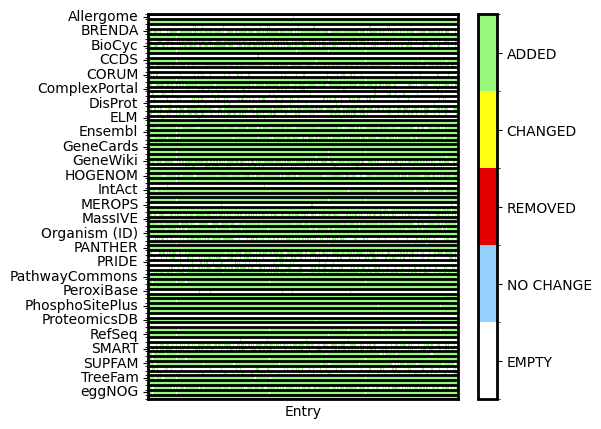

In [14]:
df_database = df_query_results.reset_index(drop=True).drop_duplicates()
if compare:
    try:
        df_previous = pd.read_csv(
            f"{database_dirpath}/{database_tag}_{version}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=["Entry"], dtype=str)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index("Entry"), df_database.set_index("Entry")
    )
    ax = visualize_comparison(df_comparision)

if overwrite:
    df_database.to_csv(f"{database_dirpath}/{database_tag}_{version}.tsv", sep="\t")
else:
    df_database.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{database_tag}_{version}.tsv", sep="\t"
    )
df_database

In [15]:
df_model = pd.DataFrame.from_dict(
    {"From": model_search_mapping},
    orient="columns",
)
df_model.index.name = annotation_type
df_model = df_model.reset_index(drop=False)
df_annotations = pd.merge(
    df_model, df_query_results, left_on="From", right_index=True, how="outer"
)
df_annotations = df_annotations.drop(["From"], axis=1).set_index("genes")
df_annotations

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),UniParc,CCDS,EMBL,RefSeq,BMRB,PDB,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
genes,,,,,,,,,,,,,,,,,,,,,
10007_AT1,P46926,GNPDA1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI000004D014,CCDS4272.1 [P46926-1];,AF048826;AJ002231;AF029914;AF035809;AF035804;A...,NP_005462.1 [P46926-1];XP_006714810.1 [P46926-...,NaN,1NE7;,...,MF_01241;,IPR006148;IPR004547;IPR018321;IPR037171;,PTHR11280;PTHR11280:SF8;,PF01182;,NaN,NaN,NaN,PS01161;,NaN,SSF100950;
100_AT1,P00813,ADA,9606,ALTERNATIVE PRODUCTS:,UPI000000D982,CCDS13335.1;,X02994;X02189;X02190;X02191;X02192;X02193;X021...,NP_000013.2;,NaN,3IAR;7RTG;,...,MF_00540;,IPR006650;IPR028893;IPR001365;IPR006330;IPR032...,PTHR11409;PTHR11409:SF43;,PF00962;,NaN,NaN,NaN,PS00485;,NaN,SSF51556;
10201_AT1,O75414,NME6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI000012FE8A,CCDS77733.1 [O75414-3];CCDS77734.1 [O75414-1];...,AF051941;U90449;AK294809;AK297364;AK222555;AC1...,NP_001295355.1 [O75414-1];NP_001295356.1 [O754...,NaN,NaN,...,NaN,IPR034907;IPR036850;IPR037994;IPR001564;IPR023...,PTHR46956;PTHR46956:SF1;,PF00334;,NaN,PR01243;,NaN,PS00469;,SM00562;,SSF54919;
10257_AT1,O15439,ABCC4,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI00001A36E6,CCDS45061.1 [O15439-3];CCDS76643.1 [O15439-4];...,AF071202;AY081219;AY207008;AF541977;AK296247;A...,NP_001098985.1 [O15439-3];NP_001288758.1 [O154...,NaN,8I4A;8I4B;8I4C;8J3W;8J3Z;,...,NaN,IPR003593;IPR011527;IPR036640;IPR003439;IPR017...,PTHR24223;PTHR24223:SF357;,PF00664;PF00005;,NaN,NaN,NaN,PS50929;PS00211;PS50893;,SM00382;,SSF90123;SSF52540;
10327_AT1,P14550,AKR1A1,9606,ALTERNATIVE PRODUCTS:,UPI000013D31D,CCDS523.1;,J04794;AF036683;AF036680;AF036681;AF036682;AF1...,NP_001189342.1;NP_001189343.1;NP_006057.1;NP_6...,NaN,2ALR;,...,NaN,IPR020471;IPR044481;IPR018170;IPR023210;IPR036...,PTHR11732:SF507;PTHR11732;,PF00248;,PIRSF000097;,PR00069;,NaN,PS00798;PS00062;PS00063;,NaN,SSF51430;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8867_AT2,O43426,SYNJ1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000206D91,CCDS33540.3 [O43426-2];CCDS54483.1 [O43426-4];,AF009039;AF009040;AB020717;AP000275;AP000276;A...,NP_001153774.1 [O43426-4];NP_001153778.1;NP_00...,NaN,1W80;2DNR;2VJ0;7A0V;,...,NaN,IPR036691;IPR005135;IPR046985;IPR000300;IPR012...,PTHR11200;PTHR11200:SF158;,PF08952;PF03372;PF02383;,NaN,NaN,NaN,PS50102;PS50275;,SM01165;SM00128;,SSF56219;SSF54928;
9162_AT1,O75912,DGKI,9606,ALTERNATIVE PRODUCTS:,UPI000012DD23,CCDS5845.1;,AF061936;CH236950;AH009185;,NP_001308637.1;NP_001308638.1;NP_001308639.1;N...,NaN,NaN,...,NaN,IPR002110;IPR036770;IPR017438;IPR047486;IPR047...,PTHR11255;PTHR11255:SF92;,PF12796;PF00130;PF00609;PF00781;,NaN,NaN,NaN,PS50297;PS50088;PS50146;,SM00248;SM00109;SM00045;SM00046;,SSF48403;SSF111331;
9429_AT1,Q9UNQ0,ABCG2,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,UPI0000001275,CCDS3628.1 [Q9UNQ0-1];CCDS58910.1 [Q9UNQ0-2];,AF103796;AF098951;AB056867;AB051855;AY017168;A...,NP_001244315.1 [Q9UNQ0-2];NP_004818.2 [Q9UNQ0-...,NaN,5NJ3;5NJG;6ETI;6FEQ;6FFC;6HBU;6HCO;6HIJ;6HZM;6...,...,NaN,IPR003593;IPR013525;IPR003439;IPR043926;IPR027...,PTHR48041;PTHR48041:SF92;,PF01061;PF19055;PF00005;,NaN,NaN,NaN,PS50893;,SM00382;,SSF52540;


### Format UniProt information for annotation files
#### Map to chosen MIRIAMs
As formatting may be needed for some MIRIAMS, keep it simple for now until formatting methods are developed. 

In [16]:
# Keeping it simple for now, group items regardless of isoforms for the time being
uniprot_miriam_mapping = get_label_miriam_mapping_UniProt(
    get_query_fields_UniProt(miriam_only=True)
)
df_annotations = df_annotations.loc[:, list(uniprot_miriam_mapping)].rename(
    uniprot_miriam_mapping, axis=1
)
df_annotations = df_annotations.loc[
    :,
    [
        "uniprot",
        "uniprot.isoform",
        "hgnc.symbol",
        "ncbigene",
        "ccds",
        "refseq",
        "mim",
        "drugbank",
    ],
]
df_annotations

,uniprot,uniprot.isoform,hgnc.symbol,ncbigene,ccds,refseq,mim,drugbank
genes,,,,,,,,
10007_AT1,P46926,ALTERNATIVE PRODUCTS: Event=Alternative splic...,GNPDA1,10007;,CCDS4272.1 [P46926-1];,NP_005462.1 [P46926-1];XP_006714810.1 [P46926-...,601798;,DB02445;DB02379;DB03951;
100_AT1,P00813,ALTERNATIVE PRODUCTS:,ADA,100;,CCDS13335.1;,NP_000013.2;,102700;608958;,DB07711;DB07783;DB07786;DB04218;DB07785;DB0301...
10201_AT1,O75414,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NME6,10201;,CCDS77733.1 [O75414-3];CCDS77734.1 [O75414-1];...,NP_001295355.1 [O75414-1];NP_001295356.1 [O754...,608294;,NaN
10257_AT1,O15439,ALTERNATIVE PRODUCTS: Event=Alternative splic...,ABCC4,10257;,CCDS45061.1 [O15439-3];CCDS76643.1 [O15439-4];...,NP_001098985.1 [O15439-3];NP_001288758.1 [O154...,605250;,DB00718;DB00770;DB01076;DB00171;DB01327;DB0048...
10327_AT1,P14550,ALTERNATIVE PRODUCTS:,AKR1A1,10327;,CCDS523.1;,NP_001189342.1;NP_001189343.1;NP_006057.1;NP_6...,103830;,DB08904;DB09130;DB00997;DB00898;DB06077;DB0015...
...,...,...,...,...,...,...,...,...
8867_AT2,O43426,ALTERNATIVE PRODUCTS: Event=Alternative splic...,SYNJ1,8867;,CCDS33540.3 [O43426-2];CCDS54483.1 [O43426-4];,NP_001153774.1 [O43426-4];NP_001153778.1;NP_00...,604297;615530;617389;,NaN
9162_AT1,O75912,ALTERNATIVE PRODUCTS:,DGKI,9162;,CCDS5845.1;,NP_001308637.1;NP_001308638.1;NP_001308639.1;N...,604072;,DB14001;
9429_AT1,Q9UNQ0,ALTERNATIVE PRODUCTS: Event=Alternative splic...,ABCG2,9429;,CCDS3628.1 [Q9UNQ0-1];CCDS58910.1 [Q9UNQ0-2];,NP_001244315.1 [Q9UNQ0-2];NP_004818.2 [Q9UNQ0-...,138900;603756;614490;,DB12001;DB08916;DB11363;DB00437;DB12015;DB0349...


,genes,uniprot,uniprot.isoform,hgnc.symbol,ncbigene,ccds,refseq,mim,drugbank
0,10007_AT1,P46926,P46926-1,GNPDA1,10007,CCDS4272.1,NP_005462.1;XP_006714810.1,601798,DB02445;DB02379;DB03951
1,100_AT1,P00813,P00813-1,ADA,100,CCDS13335.1,NP_000013.2,102700;608958,DB07711;DB07783;DB07786;DB04218;DB07785;DB0301...
2,10201_AT1,O75414,O75414-1,NME6,10201,CCDS77734.1,NP_001295355.1;NP_001295356.1;NP_001295357.1,608294,NaN
3,10257_AT1,O15439,O15439-1,ABCC4,10257,CCDS9474.1,NP_005836.2,605250,DB00718;DB00770;DB01076;DB00171;DB01327;DB0048...
4,10327_AT1,P14550,P14550-1,AKR1A1,10327,CCDS523.1,NP_001189342.1;NP_001189343.1;NP_006057.1;NP_6...,103830,DB08904;DB09130;DB00997;DB00898;DB06077;DB0015...
...,...,...,...,...,...,...,...,...,...
344,8867_AT2,O43426,O43426-2,SYNJ1,8867,CCDS33540.3,NP_982271.2,604297;615530;617389,NaN
345,9162_AT1,O75912,O75912-1,DGKI,9162,CCDS5845.1,NP_001308637.1;NP_001308638.1;NP_001308639.1;N...,604072,DB14001
346,9429_AT1,Q9UNQ0,Q9UNQ0-1,ABCG2,9429,CCDS3628.1,NP_004818.2;XP_011530722.1,138900;603756;614490,DB12001;DB08916;DB11363;DB00437;DB12015;DB0349...
347,9468_AT1,Q9Y5K3,Q9Y5K3-1,PCYT1B,9468,CCDS14213.1,NP_004836.2,300948,DB00122;DB14006


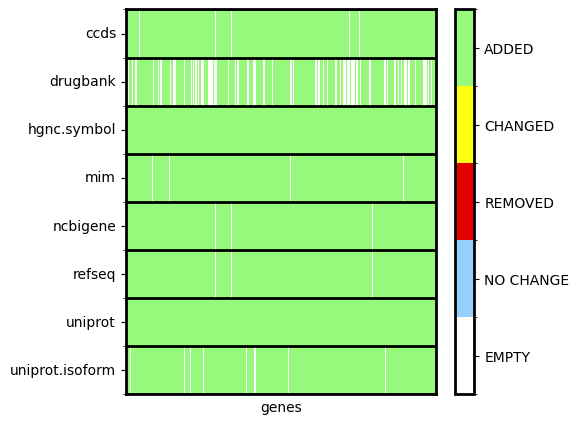

In [17]:
# Identify isoforms
df_isoforms = df_annotations.loc[:, ["uniprot", "uniprot.isoform"]].copy()
df_isoforms = parse_isoforms_UniProt(df_isoforms, add_canonical=True)
double_check = []
for gene, (uniprot_id, isoforms) in df_isoforms.loc[
    :, ["uniprot", "uniprot.isoform"]
].iterrows():
    isoforms = isoforms.split(";")
    isonum = gene.split("_AT")[-1]
    expected_isoform = f"{uniprot_id}-{isonum}"
    if expected_isoform in isoforms:
        df_isoforms.loc[gene, "uniprot.isoform"] = expected_isoform
    else:
        double_check += [gene]
        df_isoforms.loc[gene, "uniprot.isoform"] = float("nan")

df_annotations["uniprot.isoform"] = df_isoforms["uniprot.isoform"]
columns = df_annotations.columns.difference(
    [
        # Uniprot, UniProt Isoform and the "canonical" custom column are not formatted for isoforms
        "uniprot",
        "uniprot.isoform",
        "uniprot.canonical",
    ]
)

for idx, row in df_annotations.loc[:, columns].iterrows():
    uniprot_id, isoform_id = df_isoforms.loc[
        idx, ["uniprot", "uniprot.isoform"]
    ].fillna("")
    # No isoform ID set, just aggregate all without regards to isoform.
    row = row.apply(lambda x: get_isoform_value_from_entry_UniProt(x, isoform_id))
    df_annotations.loc[idx, columns] = row.values
df_annotations = df_annotations.reset_index(drop=False)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # Comparisons should be done with annotation type as index to ensure correct entries get compared.
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{database_tag}.tsv", sep="\t"
    )
df_annotations

#### Double check
These didn't have isoforms, with current database mapping.

In [18]:
df_annotations.set_index(annotation_type).loc[double_check]

,uniprot,uniprot.isoform,hgnc.symbol,ncbigene,ccds,refseq,mim,drugbank
genes,,,,,,,,
10327_AT2,P14550,NaN,AKR1A1,10327,CCDS523.1,NP_001189342.1;NP_001189343.1;NP_006057.1;NP_6...,103830,DB08904;DB09130;DB00997;DB00898;DB06077;DB0015...
221823_AT2,P21108,NaN,PRPS1L1,221823,CCDS47552.1,NP_787082.1,611566,NaN
226_AT3,P04075,NaN,ALDOA,226,CCDS10668.1;CCDS58450.1,NP_000025.1;NP_001121089.1;NP_001230106.1;NP_9...,103850;611881,DB04733;DB02512;DB11638;DB04326;DB08240;DB0159...
2592_AT3,P07902,NaN,GALT,2592,CCDS59122.1;CCDS6565.1,NP_000146.2;NP_001245261.1,230400;606999,NaN
3098_AT5,P19367,NaN,HK1,3098,CCDS7289.1;CCDS7291.1;CCDS7292.1,NP_000179.2;NP_001309293.1;NP_277031.1;NP_2770...,142600;235700;605285;617460;618547,DB02007;DB02379;DB01914;DB09341;DB09502;DB0626...
318_AT2,P50583,NaN,NUDT2,318,CCDS6552.1,NP_001152.1;NP_001231319.1;NP_671701.1;NP_6717...,602852;619844,NaN
318_AT3,P50583,NaN,NUDT2,318,CCDS6552.1,NP_001152.1;NP_001231319.1;NP_671701.1;NP_6717...,602852;619844,NaN
5052_AT2,Q06830,NaN,PRDX1,5052,CCDS522.1,NP_001189360.1;NP_002565.1;NP_859047.1;NP_8590...,176763,DB11638;DB09130;DB09221;DB01593;DB14487;DB1453...
5052_AT3,Q06830,NaN,PRDX1,5052,CCDS522.1,NP_001189360.1;NP_002565.1;NP_859047.1;NP_8590...,176763,DB11638;DB09130;DB09221;DB01593;DB14487;DB1453...
